## Model

In [1]:
name = 'Res_204'
batch_size = 128
model_basename = 'ResNN3'
train_steps = 20000
import sys; sys.argv=['', 
                      '--log_dir', '/nfs/P100/DSC/log/%s'%name, 
                      '--model_dir', '/nfs/P100/DSC/model/%s'%name, 
                      '--batch_size', '%d'%batch_size,
                      '--model_basename', model_basename,
                      '--train_steps', '%d'%train_steps,
                      '--learning_rate', '2e-4',
                      '--Is_BN', 'True',
                      '--weight_decay','1e-2',
                     ];
del sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tftool.main import Main

In [4]:
class RunWapper(Main):
    def __init__(self, *args, **kwargs):
        super(RunWapper, self).__init__(*args, **kwargs)
    def __call__(self):
        """an example for constructing network model"""
        self.train_filenames = ["/nfs/P100/DSC/data/training.tfrecords"]
        self.valid_filenames = ["/nfs/P100/DSC/data/valid.tfrecords"]
        self.Is_training = tf.placeholder(tf.bool,shape=[],name='is_train')
        x, y_ = self.loaddata(shuffle=True)
        net = self.inference(x, is_training=self.Is_training)
        loss = self.Loss_fn(self, net=net, y_=y_)
        train_op = self.optimizer(loss, gclip=1.0)
        self.train(loss, train_op)                                  
dsc = RunWapper()
print dsc.FLAGS

INFO:tensorflow:(<class 'tftool.main.Main'>, <class 'tftool.Train.Train'>, <class 'tftool.Network.Model'>, <class 'tftool.InputPipeline.InputPipeline'>, <class 'tftool.Utils.Toolkit'>, <class 'tftool.Base.Base'>, <type 'object'>)
Namespace(Is_BN=True, batch_size=128, learning_rate=0.0002, log_dir='/nfs/P100/DSC/log/Res_204', model_basename='ResNN3', model_dir='/nfs/P100/DSC/model/Res_204', train_steps=20000, weight_decay=0.01)


In [5]:
config = tf.ConfigProto(allow_soft_placement=True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
config.gpu_options.allow_growth = True
dsc.opt = tf.train.AdamOptimizer
#dsc.opt = tf.train.GradientDescentOptimizer
dsc.Is_summary = True
dsc.update_log_step =100
dsc.save_per_steps = 1000
dsc.print_log = False 
dsc.valid_size = 6144
dsc.config = config

### training

In [ ]:
dsc()

---
## Evaluation

In [6]:
data_test = np.load('/nfs/P100/DSC/data/test.npy')

In [7]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [8]:
data_test_mean = data_test['flux'].mean(axis=1)
data_test['flux'] = data_test['flux'] - data_test_mean[:,None]*np.ones([data_test_mean.shape[0],4000])
loss, prob = dsc.eval(data_test)

float32 (6150, 4000)
int32 (6150,)
INFO:tensorflow:loop number: 49
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 4000), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
INFO:tensorflow:load variable from /nfs/P100/DSC/model/Res_204/ResNN3-34999
INFO:tensorflow:Restoring parameters from /nfs/P100/DSC/model/Res_204/ResNN3-34999


100%|██████████| 49/49 [00:02<00:00, 18.94it/s]


0.3644183
| class | percentage | 
|-------|-------|
| d -> d | 0.04260162601626016  | 
| s -> s | 0.8741463414634146  | 
| d -> s | 0.010731707317073172  | 
| s -> d | 0.07252032520325204  | 


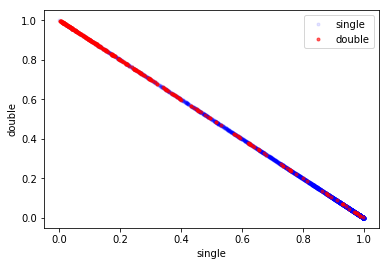

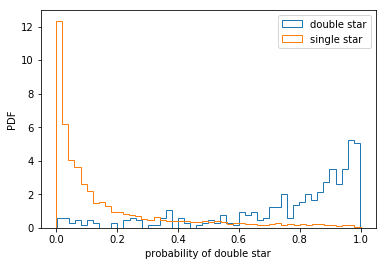

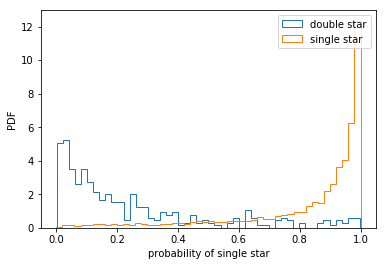

In [15]:
print loss.mean()
threshold_d = 0.5
threshold_s = 0.4
bool_gt = data_test['label']
bool_es = (prob[:,1]>threshold_d) * (prob[:,0]<threshold_s)
size_eval = data_test.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print '| class | percentage |', '\n|-------|-------|'
print '| d -> d |', np.sum(bool_dd)/float(size_eval), ' | ' # d -> d
print '| s -> s |', np.sum(bool_ss)/float(size_eval), ' | '  # s -> s
print '| d -> s |', np.sum(bool_ds)/float(size_eval), ' | '  # d -> s
print '| s -> d |', np.sum(bool_sd)/float(size_eval), ' | '  # s -> d

plt.plot(prob[bool_gt==0][:,0], prob[bool_gt==0][:,1], 'b.', label='single', alpha=0.1)
plt.plot(prob[bool_gt==1][:,0], prob[bool_gt==1][:,1], 'r.', label='double', alpha=0.6)
plt.xlabel('single')
plt.ylabel('double')
plt.legend()
plt.show()

plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of double star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_test.png'%(mid))
plt.show()

plt.hist(prob[bool_gt==1][:,0], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,0], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of single star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_test.png'%(mid))
plt.show()

#### **CNN_101** step 15000 loss=0.28170884
![show](test/CNN_101_CNN-14999_test.png)

| class | percentage | 
|-------|-------|
| d -> d | 0.042926829268292686  | 
| s -> s | 0.8585365853658536  | 
| d -> s | 0.01040650406504065  | 
| s -> d | 0.08813008130081301  | 

#### **CNN_103** step 55000 loss=0.44368657(add l2)
![show](test/CNN_103_CNN2-54999_test.png)

| class | percentage | 
|-------|-------|
| d -> d | 0.044227642276422764  | 
| s -> s | 0.8408130081300813  | 
| d -> s | 0.009105691056910569  | 
| s -> d | 0.10585365853658536  | 

#### **CNN_103** step 45000 loss=0.6191649(add l2)
![show](test/CNN_103_CNN2-44999_test.png)

| class | percentage | 
|-------|-------|
| d -> d | 0.04796747967479675  | 
| s -> s | 0.7560975609756098  | 
| d -> s | 0.005365853658536586  | 
| s -> d | 0.19056910569105692  | 

- clean validation: remove repeated data points.

In [ ]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [ ]:
data_valid = np.load('/nfs/P100/DSC/data/valid.npy')
clean_inds = np.unique(data_valid['obsid'],return_index=True)[1]
data_valid_cleaned = data_valid[clean_inds]

In [ ]:
data_valid_mean = data_valid_cleaned['flux'].mean(axis=1)
data_valid_cleaned['flux'] = data_valid_cleaned['flux'] - data_valid_mean[:,None]*np.ones([data_valid_mean.shape[0],4000])
loss, prob = dsc.eval(data_valid_cleaned)

In [ ]:
print loss.mean()
threshold = 0.5
bool_gt = data_valid_cleaned['label']
bool_es = prob[:,1]>threshold
size_eval = data_valid_cleaned.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print 'd -> d', np.sum(bool_dd)/float(size_eval)  # d -> d
print 's -> s', np.sum(bool_ss)/float(size_eval)  # s -> s
print 'd -> s', np.sum(bool_ds)/float(size_eval)  # d -> s
print 's -> d', np.sum(bool_sd)/float(size_eval)  # s -> d
plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of double star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_valid.png'%(mid))
plt.show()